In [2]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import euclidean

df= pd.read_csv('dataset_diabetes/diabetic_data.csv')
import numpy as np
df.replace({'?':np.nan},inplace=True)
df.head()

null_feature=[i for i in df.columns if df[i].isnull().sum()>=1]
print('Null features {} \n'.format(null_feature))
print('Feature \t null_count \t not_null_count')
for i in null_feature:
    print('{} \t {} \t\t {}'.format(i,df[i].isnull().sum(),df[i].count()))
    
    
#Dropping columns with count of null values around the count of not null values. As they dont provide significant information or 
#mostly contains null data
df.drop(['weight','payer_code','medical_specialty'],axis=1,inplace=True)


df['age'] = df['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95})

df['readmitted'] = df['readmitted'].replace({'>30':1,'<30':1,'NO':0})


for i in df.select_dtypes(include=['int', 'float']).columns.to_list():
    print('The numeric feature is {} \n The value counts are {}'.format(i,df[i].value_counts()) )
    
df.drop(columns=['encounter_id','patient_nbr'],inplace=True,axis=1)

meds=['max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
      'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
      'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
      'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
df_value_counts=pd.DataFrame()
for i in meds:
    value_counts=df[i].value_counts()
    percent = []
    for j in value_counts.index:
        percent.append(value_counts[j] *100/ len(df))
    ## PErcentage dataframe to store the feature, its unique values, the count and the percentage
    df_temp=pd.DataFrame({'Feature':i,'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percent})
    df_value_counts=pd.concat([df_value_counts,df_temp],ignore_index=True)
df_value_counts.head(80)  

skewed_data=df_value_counts[df_value_counts['Percentage']>95]['Feature'].to_list()
df.drop(columns=skewed_data,inplace=True)

label_encoded_columns=[]
for i in df.select_dtypes(include=['object']).columns.to_list():
    if i not in skewed_data:
        label_encoded_columns.append(i)
## The columns remaining after all the EDA that are to be label encoded

df_cleaned_dia=df.copy()
## creating the copy of data before performing label encoding and one hot encoding
one_hot = pd.get_dummies(df_cleaned_dia[['gender','race']])
label_encoded_columns.remove('diag_1')
label_encoded_columns.remove('diag_2')
label_encoded_columns.remove('diag_3')
label_encoded_columns.remove('gender')
label_encoded_columns.remove('race')
# combine the one-hot encoded columns with the original dataframe
df_cleaned_dia = pd.concat([df_cleaned_dia, one_hot], axis=1)
df_cleaned_dia.drop(columns=['diag_1','diag_2','diag_3','gender','race'],inplace=True)
##
df_cleaned_dia[label_encoded_columns]=df_cleaned_dia[label_encoded_columns].swifter.apply(LabelEncoder().fit_transform)


df_cleaned_dia.shape

Null features ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3'] 

Feature 	 null_count 	 not_null_count
race 	 2273 		 99493
weight 	 98569 		 3197
payer_code 	 40256 		 61510
medical_specialty 	 49949 		 51817
diag_1 	 21 		 101745
diag_2 	 358 		 101408
diag_3 	 1423 		 100343
The numeric feature is encounter_id 
 The value counts are 2278392      1
190792044    1
190790070    1
190789722    1
190786806    1
            ..
106665324    1
106657776    1
106644876    1
106644474    1
443867222    1
Name: encounter_id, Length: 101766, dtype: int64
The numeric feature is patient_nbr 
 The value counts are 88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64
The numeric feature is age 
 The value counts are 75    26068
65    22483
55    17256
85    17197
45     9685
35     3775
95     279

Pandas Apply:   0%|          | 0/11 [00:00<?, ?it/s]

(101766, 32)

In [3]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
def GMM_initialization(df,k):
    number_of_rows=df.shape[0]
    number_of_columns=df.shape[1]
    means_matrix = df.sample(n=k).values
    identity_matrix=np.eye(number_of_columns)
    covariance_matrix=np.array([identity_matrix]*k)
    weights_matrix=np.array([float(1/k)]*k)
    return means_matrix,covariance_matrix,weights_matrix,number_of_rows,number_of_columns
    
    
def calculate_posterior(data,means_matrix,covariance_matrix,weights_matrix,k,number_of_columns):
    posterior=np.zeros(k)
    for i in range(k):
        try:
            pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.eye(covariance_matrix[i].shape[0]) * 1e-2, rcond=1e-10)
            posterior[i] = multivariate_normal.pdf(data, mean=means_matrix[i], cov=pseudo_inverse)
        except Exception as e:
            continue
    return posterior*weights_matrix/(posterior*weights_matrix).sum()
    
def maintain_k_clusters(labels,k):
    unique_values, value_counts = np.unique(labels, return_counts=True)
    missing_labels=[i for i in range(k) if i not in unique_values]
    unique_values_to_be_replaced=[unique_values[i] for i in np.where(value_counts > 1)[0]]

    indices=[i for i in range(len(labels))    if labels[i] in unique_values_to_be_replaced]
    random_indices = np.random.choice(indices, size=len(missing_labels), replace=False)
    for i,val in enumerate(random_indices):
        labels[val]=missing_labels[i]
    return labels


def sum_of_square_error_em(new_centroids, data, labels):
    columns = data.columns
    # Join the data dataframe and the labels dataframe
    data = data.join(labels)
    # Rename the '0' column of the labels dataframe to 'Label'
    data.rename(columns={0:'Label'}, inplace=True)
    sse = []
    # Compute the distance between each data point and its assigned centroid
    for i in range(len(new_centroids)):
        distance = np.sum(np.square(data[data['Label']==i][columns] - new_centroids.iloc[i][columns],dtype=np.float64), axis=1)
        #print(distance)
        sse.append(distance.sum())
    # Return the sum of squared errors
    
    a=sum(sse)   
    return a

def Calinski_index_em(df_data,clusters):
    ch_score = calinski_harabasz_score(df_data, clusters)
    return ch_score
    


def GMM(df_cleaned_dia,k,tao):
    scaler = MinMaxScaler()
    scaler.fit(df_cleaned_dia)
    scaled_input=scaler.transform(df_cleaned_dia)
    
    scaled_input_df= pd.DataFrame(scaled_input,columns=df_cleaned_dia.columns)
    
    means_matrix,covariance_matrix,weights_matrix,number_of_rows,number_of_columns= GMM_initialization(scaled_input_df,k)
    likelihood=0
    means_matrix_initial=means_matrix
    for i in range(k):
        try:
            
            pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.diag(np.ones(covariance_matrix[i].shape[0]) * 1e-10))
            likelihood=likelihood+weights_matrix[i]*multivariate_normal.logpdf(scaled_input,means_matrix[i], pseudo_inverse)
        except Exception as e:
            continue
    log_likelihood_old=np.sum(likelihood)
    old_means_matrix_df=pd.DataFrame(means_matrix)
    posterior_probability = np.zeros((scaled_input.shape[0], k))
    iterations=0
    
    while (True):
        iterations+=1
        # Expectation
        for i in range(scaled_input.shape[0]):
            posterior_probability[i] = calculate_posterior(scaled_input[i], means_matrix,covariance_matrix,weights_matrix,k,number_of_columns)
        
        # Maximization
        posterior_probability=np.nan_to_num(posterior_probability, nan=0)
        for i in range(k): 
            # Calculating weight
            weight = posterior_probability[:, i].sum()
            #print(weight)
            # Updating each centroid
            means_matrix[i] = (posterior_probability[:, i] @ scaled_input) / weight
            #print(1,means_matrix[i])
            # Subtracting the mean value from data
            scaled_input_diff = scaled_input - means_matrix[i]

            # Update the covariance matrix 
            covariance_matrix[i] = (posterior_probability[:, i] * scaled_input_diff.T @ scaled_input_diff) / weight

            # Update the weights matrix
            weights_matrix[i] = weight / number_of_rows
        

        likelihood=0
        for i in range(k):
            try:
                pseudo_inverse = np.linalg.pinv(covariance_matrix[i] + np.diag(np.ones(covariance_matrix[i].shape[0]) * 1e-10))
                likelihood=likelihood+weights_matrix[i]*multivariate_normal.logpdf(scaled_input,means_matrix[i], sudo_inverse)
            except Exception as e:
                continue
        log_likelihood_new =np.sum(likelihood)
        
        new_means_matrix_df=pd.DataFrame(means_matrix)
        distance = []
        for col in new_means_matrix_df.columns:
            col_distance = euclidean(old_means_matrix_df[col], new_means_matrix_df[col])
            distance.append(col_distance)
        tao_calculated=sum(distance)/k 
        
        
        
        if tao_calculated< tao:#log_likelihood_new>log_likelihood_old and 100*((log_likelihood_new - log_likelihood_old) / log_likelihood_old)<tao:
            
            print("Converged")
            labels=np.argmax(posterior_probability,axis=1)
            labels=maintain_k_clusters(labels,k)
            labels_df=pd.DataFrame(labels)
            means_matrix_df=pd.DataFrame(means_matrix,columns=scaled_input_df.columns)
            sse=sum_of_square_error_em(means_matrix_df, scaled_input_df, labels_df)
            clainski= Calinski_index_em(scaled_input_df,labels_df)
            return sse,clainski,means_matrix_initial
        #else:
            #log_likelihood_old=log_likelihood_new
            
        if iterations>100:
            print("Max iteration reached")
            labels=np.argmax(posterior_probability,axis=1)
            labels=maintain_k_clusters(labels,k)
            labels_df=pd.DataFrame(labels)
            means_matrix_df=pd.DataFrame(means_matrix,columns=scaled_input_df.columns)
            sse=sum_of_square_error_em(means_matrix_df, scaled_input_df, labels_df)
            clainski= Calinski_index_em(scaled_input_df,labels_df)
            return sse,clainski,means_matrix_initial
        
    


In [4]:
error_matrix_em=[]

for i in range(2,6):
    for j in range(1,21):
        sse,clainski,means_matrix_initial=GMM(df_cleaned_dia,i,10)
        error_matrix_em.append([i,sse,clainski])
        
error_df_em= pd.DataFrame(error_matrix_em,columns=['number_of_cluster', 'sse','clainski']) 

Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Converged


/N/soft/rhel7/python/3.9.8/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
error_df_em.to_csv('6_em_minmax.csv',index=False)

In [6]:
error_df_em

,number_of_cluster,sse,clainski
0,2,199794.407077,14014.987414
1,2,181955.900858,22414.786437
2,2,195228.589626,12904.486753
3,2,195689.762065,15391.685019
4,2,192673.620510,13174.569214
...,...,...,...
75,5,162123.125143,14948.183371
76,5,165720.286279,13441.844495
77,5,154814.817041,16305.155941
78,5,179397.530043,10686.114962


In [7]:
error_df_em_poisson=pd.read_csv('6_em_poisson.csv')
error_df_em_exp=pd.read_csv('6_em_exp.csv')
error_df_em_normal=pd.read_csv('6_em_minmax.csv')

error_df_em_poisson['algo']='em_poisson'
error_df_em_exp['algo']='em_exponential'
error_df_em_normal['algo']='em_normal'

In [8]:
run_time_diab=pd.DataFrame()
run_time_diab=pd.concat( [ error_df_em_poisson[['algo','number_of_cluster','sse','clainski']],
    error_df_em_exp[['algo','number_of_cluster', 'sse','clainski']],
     error_df_em_normal[['algo','number_of_cluster', 'sse','clainski']]                     
                        ],ignore_index=True )

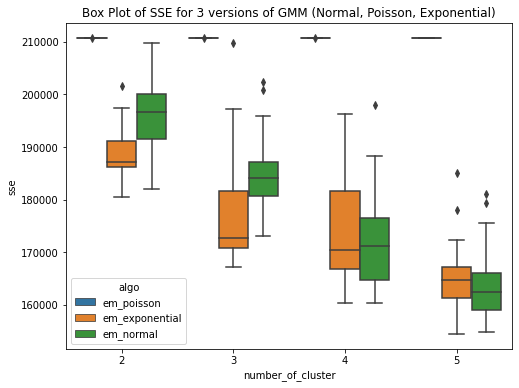

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='sse', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['em_poisson','em_exponential','em_normal'])],ax=ax);
plt.title('Box Plot of SSE for 3 versions of GMM (Normal, Poisson, Exponential)')
plt.show()

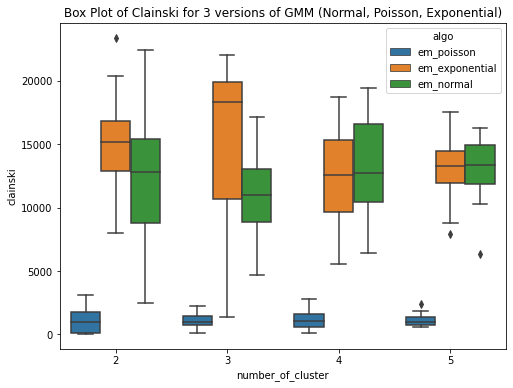

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(x='number_of_cluster', y='clainski', hue='algo',
            data=run_time_diab[run_time_diab['algo'].isin (['em_poisson','em_exponential','em_normal'])],ax=ax);
plt.title('Box Plot of Clainski for 3 versions of GMM (Normal, Poisson, Exponential)')
plt.show()